Download the dataset

In [1]:
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!gdown 169wvBTxkEt06n_QcsOqoYNedr3zmAOvM 

Downloading...
From: https://drive.google.com/uc?id=169wvBTxkEt06n_QcsOqoYNedr3zmAOvM
To: /content/Dataset.zip
100% 2.73G/2.73G [00:29<00:00, 91.8MB/s]


In [3]:
!unzip /content/Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Tumor/tumor_3052.jpg    
  inflating: Tumor/tumor_3053.jpg    
  inflating: Tumor/tumor_3054.jpg    
  inflating: Tumor/tumor_3055.jpg    
  inflating: Tumor/tumor_3056.jpg    
  inflating: Tumor/tumor_3057.jpg    
  inflating: Tumor/tumor_3058.jpg    
  inflating: Tumor/tumor_3059.jpg    
  inflating: Tumor/tumor_306.jpg     
  inflating: Tumor/tumor_3060.jpg    
  inflating: Tumor/tumor_3061.jpg    
  inflating: Tumor/tumor_3062.jpg    
  inflating: Tumor/tumor_3063.jpg    
  inflating: Tumor/tumor_3064.jpg    
  inflating: Tumor/tumor_3065.jpg    
  inflating: Tumor/tumor_3066.jpg    
  inflating: Tumor/tumor_3067.jpg    
  inflating: Tumor/tumor_3068.jpg    
  inflating: Tumor/tumor_3069.jpg    
  inflating: Tumor/tumor_307.jpg     
  inflating: Tumor/tumor_3070.jpg    
  inflating: Tumor/tumor_3071.jpg    
  inflating: Tumor/tumor_3072.jpg    
  inflating: Tumor/tumor_3073.jpg    
  inflating: Tumor/tumor_3074.jpg    

Import necessary libraries

In [4]:
import os
import pandas as pd
import numpy as np
import shutil, math, cv2, json, random
from tqdm import tqdm
from keras.layers import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

##Preprocess the dataset

Downsample to reduce bias

In [5]:
source_1 = "/content/Dataset/Normal"
source_2 = "/content/Dataset/Renal_Cyst"

files_1 = os.listdir(source_1)
files_2 = os.listdir(source_2)

for i, j in enumerate(files_1):
    if i >= len(files_2):
        os.remove(os.path.join(source_1, j))

In [6]:
sdir = '/content/Dataset'

def make_dataframes(sdir):
    bad_images = []
    good_ext = ['jpg', 'jpeg', 'png']
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index + 1:]
            if ext in good_ext:
                try:
                    img = cv2.imread(fpath)
                    shape = img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123,
                                         stratify=dummy_df['labels'])
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)

    ht = 0
    wt = 0
    count = 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            wt += w
            ht += h
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('number of classes in processed dataset= ', class_count)
    counts = list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts),
          '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

    return train_df, test_df, valid_df, classes, class_count


train_df, test_df, valid_df, classes, class_count = make_dataframes(sdir)

Renal_Cyst             : 100%|█████████████████████████████████████████| 3709/3709 [00:19<00:00, 193.57file/s]


number of classes in processed dataset=  2
the maximum files in any class in train_df is  2967   the minimum files in any class in train_df is  2967
train_df length:  5934   test_df length:  742   valid_df length:  742
average image height=  568   average image width=  596  aspect ratio h/w=  0.9530201342281879


In [7]:
def normalized_data(img):
    img -= np.mean(img, axis=(0,1))
    img /= (np.std(img, axis=(0,1)) + 1e-7)
    return img 

In [27]:
batch_size = 16
img_size = (224, 224)
input_shape = (224, 224, 3)

def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator(
        horizontal_flip=True, 
        vertical_flip=True,
        rotation_range=90,
        preprocessing_function=lambda img: normalized_data(img))
    t_and_v_gen = ImageDataGenerator(
        horizontal_flip=True, 
        vertical_flip=True,
        rotation_range=90,
        preprocessing_function=lambda img: normalized_data(img)
    )
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    train_ds = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=True)

    msg = '{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    valid_ds = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=False)

    test_len = len(test_df)
    test_batch_size = sorted([int(test_len / n) for n in range(1, test_len + 1)
                              if test_len % n == 0 and test_len / n<=80], reverse=False)[0]
    test_steps = int(test_len / test_batch_size)
    msg = '{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    test_ds = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', batch_size=batch_size, shuffle=False)

    classes = list(train_ds.class_indices.keys())
    class_count = len(classes)
    print('test batch size: ', test_batch_size, 'test steps: ', test_steps, 'number of classes : ', class_count)

    return train_ds, test_ds, valid_ds

train_ds, test_ds, valid_ds = make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 5934 validated image filenames belonging to 2 classes.
Found 742 validated image filenames belonging to 2 classes.
Found 742 validated image filenames belonging to 2 classes.
test batch size:  1 test steps:  742 number of classes :  2


### **Construct the neural network**

In [32]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Create the base model
base_model = DenseNet121(weights='imagenet', include_top=False, 
                         input_shape=input_shape)

# Freeze the base model to prevent its weights from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer with a single output for binary classification
predictions = Dense(2, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [33]:
model.compile(optimizer='adam', 
                     loss = "categorical_crossentropy",
                     metrics=['accuracy', 'AUC'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

Train the model

In [34]:
history = model.fit(train_ds, epochs=2, batch_size=batch_size, 
                    validation_data=valid_ds)

Epoch 1/2
371/371 [==============================] - 145s 343ms/step - loss: 0.2344 - accuracy: 0.9142 - auc: 0.9451 - val_loss: 0.1258 - val_accuracy: 0.9663 - val_auc: 0.9846
Epoch 2/2
371/371 [==============================] - 123s 332ms/step - loss: 0.0948 - accuracy: 0.9759 - auc: 0.9917 - val_loss: 0.0811 - val_accuracy: 0.9771 - val_auc: 0.9937


Plot the loss, accuracy, and AUC

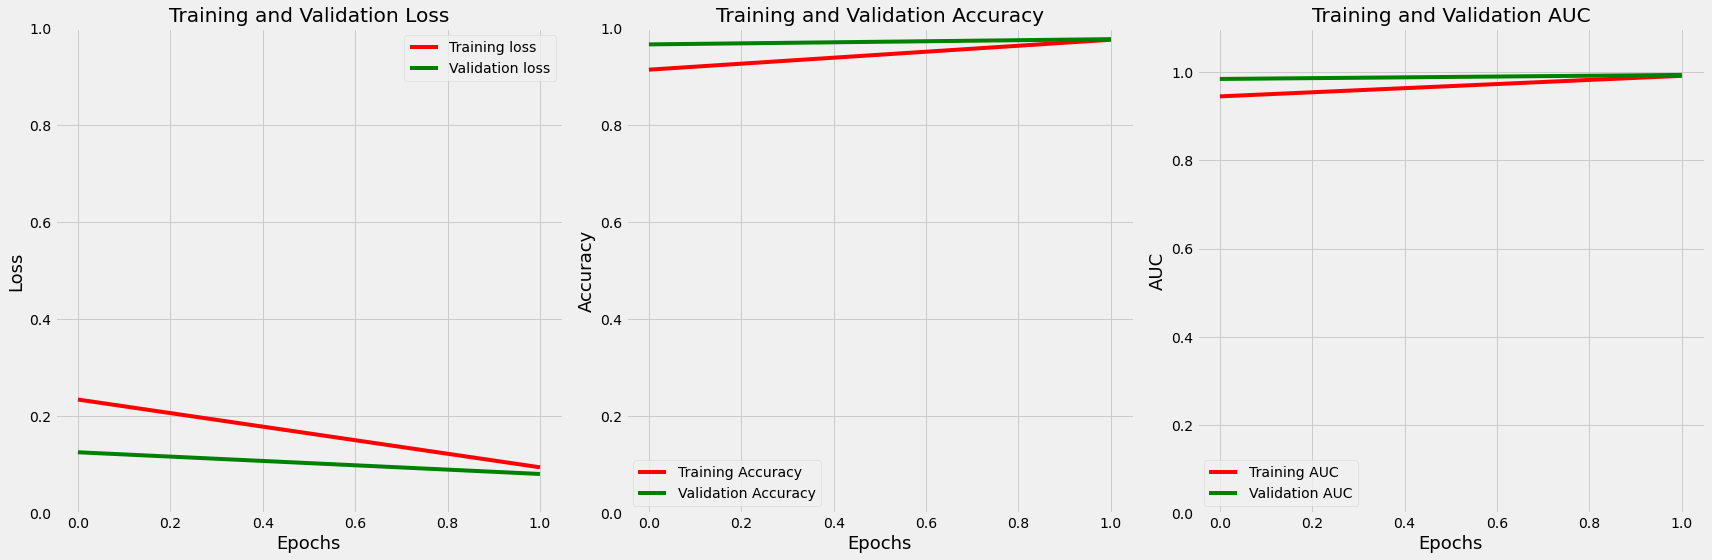

In [35]:
def plot_auc_acc_loss(history, epochs):
    tacc = history.history['accuracy']
    tloss = history.history['loss']
    tauc = history.history['auc']

    vacc = history.history['val_accuracy']
    vloss = history.history['val_loss']
    vauc = history.history['val_auc']

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
    axes[0].plot(tloss, 'r', label='Training loss')
    axes[0].plot(vloss, 'g', label='Validation loss')
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    axes[1].plot(tacc, 'r', label='Training Accuracy')
    axes[1].plot(vacc, 'g', label='Validation Accuracy')
    axes[1].set_ylim(0, 1)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()

    axes[2].plot(tauc, 'r', label='Training AUC')
    axes[2].plot(vauc, 'g', label='Validation AUC')
    axes[2].set_ylim(0, 1.1)
    axes[2].set_title('Training and Validation AUC')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('AUC', fontsize=18)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return Epochs

Epochs = plot_auc_acc_loss(history, epochs=10)

Confusion matrix

47/47 [==============================] - 14s 287ms/step
there were 9 errors in 742 tests for an accuracy of  98.79%


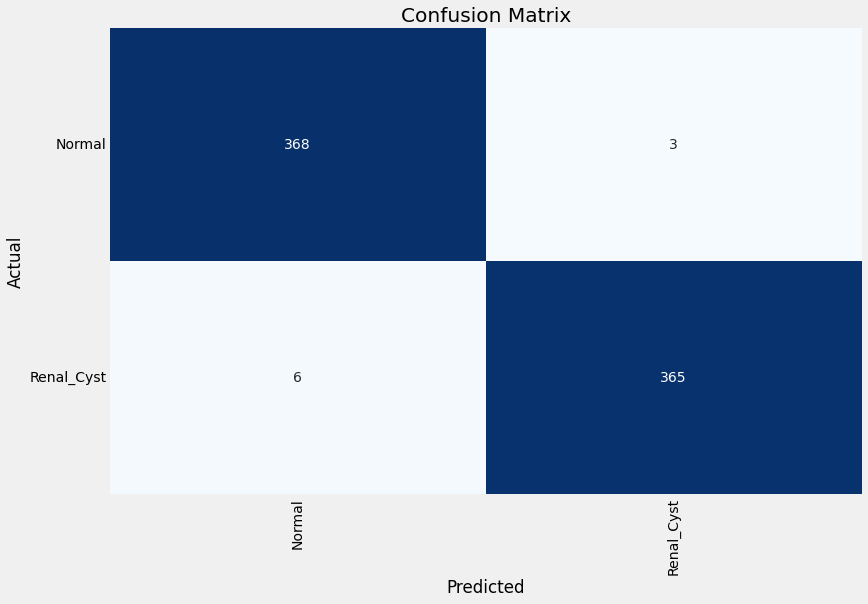



Classification Report:
----------------------
               precision    recall  f1-score   support

      Normal     0.9840    0.9919    0.9879       371
  Renal_Cyst     0.9918    0.9838    0.9878       371

    accuracy                         0.9879       742
   macro avg     0.9879    0.9879    0.9879       742
weighted avg     0.9879    0.9879    0.9879       742



In [39]:
def predictor(test_ds):
    y_pred, error_list, error_pred_list = [], [], []
    y_true = test_ds.labels
    classes = list(test_ds.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = tf.argmax(model.predict(test_ds), axis=1)
    tests = len(preds)
    for i in range(tests):
        pred_index = preds[i]
        true_index = test_ds.labels[i]
        if pred_index != true_index:
            errors += 1
            file = test_ds.filenames[i]
            error_list.append(file)
            error_classes = classes[pred_index]
            error_pred_list.append(error_classes)
        y_pred.append(pred_index)

    acc = (1 - errors / tests) * 100
    msg = f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%'
    print(msg)
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100

    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("\n\nClassification Report:\n----------------------\n", clr)

    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score = predictor(test_ds)